In [40]:
import os
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle

%matplotlib inline

def flatten_dict(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            val = [val]
        if isinstance(val, list):
            for subdict in val:
                deeper = flatten_dict(subdict).items()
                out.update({key + '.' + key2: val2 for key2, val2 in deeper})
        else:
            out[key] = val
    return out

prefix = "../vardim_icml_realizable_2022-05-04/"
# prefix = "../nonhlsrealizable_c1_2022-05-02/"
folders = [
    # f"{prefix}leader",
    # f"{prefix}leaderselect_mineig",
    # f"{prefix}leaderselect_mineig_norm",
    # f"{prefix}leaderselect_avg_quad",
    f"{prefix}egreedyglrt_0",
    f"{prefix}egreedyglrt_1",
    f"{prefix}egreedyglrt_2",
    f"{prefix}egreedyglrt_3",
    f"{prefix}egreedyglrt_4",
    f"{prefix}egreedyglrt_5",
    # f"{prefix}linucb_0",
    # f"{prefix}linucb_1",
    # f"{prefix}linucb_2",
    # f"{prefix}linucb_3",
    # f"{prefix}linucb_4",
    # f"{prefix}linucb_5"
]
df = None
result_keys = []
fcnt = 0
for rootdir in folders:
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            if os.path.exists(os.path.join(d, "config.json")):
                fcnt+=1
                with open(os.path.join(d, "config.json"), "r") as jf:
                    config = json.load(jf)
                    config = flatten_dict(config)

                with open(os.path.join(d, "result.pkl"), "rb") as jf:
                    results = pickle.load(jf)
                # rank = config['newrank']
                # algo = config['algo']
                # layers = config['layers']
                # name = f"{algo}_{rank}_{layers}"
                for k in results.keys():
                    config[k] = [results[k]]
                
                result_keys = np.unique(result_keys + list(results.keys())).tolist()
                # else:
                #     assert np.all([el in result_keys for el in results.keys()])
                tdf = pd.DataFrame.from_dict(config)
                if df is None:
                    df = tdf
                else:
                    df = pd.concat((df,tdf))
            else:
                print(f"{d} not finished")



assert df.shape[0] == fcnt
print(f"result_keys:\n {result_keys}")
print(f"df.columns.to_list():\n {df.columns.to_list()}")

result_keys:
 ['regret']
df.columns.to_list():
 ['algo', 'check_every', 'check_glrt', 'delta', 'domain.datafile', 'domain.noise_param', 'domain.seed_problem', 'domain.type', 'horizon', 'linucb_rep', 'noise_std', 'normalize_mineig', 'seed', 'ucb_regularizer', 'regret']


In [41]:
df

,algo,check_every,check_glrt,delta,domain.datafile,domain.noise_param,domain.seed_problem,domain.type,horizon,linucb_rep,noise_std,normalize_mineig,seed,ucb_regularizer,regret
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,0,${domain.noise_param},True,7232031,1,"[3.1024166246165126, 3.5073644930056775, 3.507..."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,0,${domain.noise_param},True,12125598,1,"[0.0, 3.468772490850528, 4.079026464923147, 5...."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,0,${domain.noise_param},True,11396216,1,"[0.13967894956020466, 2.3388175326984952, 5.52..."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,0,${domain.noise_param},True,5035706,1,"[0.0, 0.39704566943681696, 1.117110902274173, ..."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,0,${domain.noise_param},True,5150257,1,"[4.71392963738398, 5.703256839852694, 8.152757..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,5,${domain.noise_param},True,2811825,1,"[0.5959659467595619, 1.316031179596918, 1.3160..."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,5,${domain.noise_param},True,4692096,1,"[1.1760296793046887, 1.3462466950658492, 2.373..."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,5,${domain.noise_param},True,3278453,1,"[1.5772990328630425, 4.026799282179475, 6.7881..."
0,egreedyglrt,1,True,0.01,problem_data/vardimtest_icml_realizable.npy,0.3,3,fromfile,10000,5,${domain.noise_param},True,6429502,1,"[0.39704566943681696, 2.1281436883413996, 3.85..."


keys for grouping:  ['linucb_rep']
keys for grouping:  ['algo', 'linucb_rep']
('egreedyglrt', 0)
('egreedyglrt', 1)
('egreedyglrt', 2)
('egreedyglrt', 3)
('egreedyglrt', 4)
('egreedyglrt', 5)


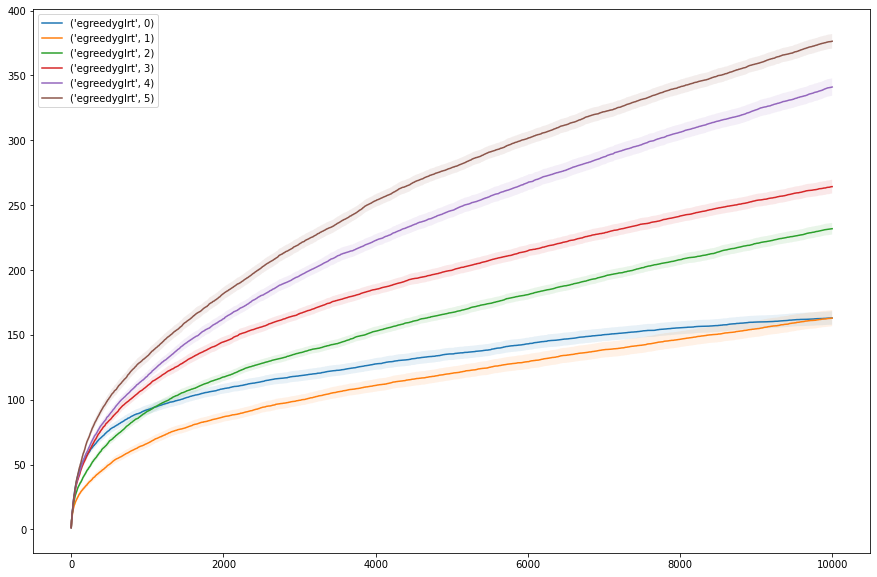

In [42]:
keys = df.columns[~df.columns.isin(result_keys+['seed'])]
m2 = (df[keys] == df[keys].iloc[0]).all()
gk = keys[~m2].values.tolist()
print("keys for grouping: ", gk)
if len(gk) == 0:
    gk = "algo"
    print("new keys for grouping: ", gk)
if "algo" not in gk:
    gkn = gk
    gk = ["algo"]
    gk.extend(gkn)
print("keys for grouping: ", gk)
grouped = df.groupby(gk)

max_t = None
plt.figure(figsize=(15,10))
data = {}
for name, group in grouped:
    print(name)
    regrets = np.stack(group['regret'].values, axis=0)
    reps = regrets.shape[0]
    mean_regret = regrets.mean(axis=0)[:max_t]
    std_regret = regrets.std(axis=0)[:max_t] / np.sqrt(reps)
    data[name] = {
        "mean_regret": mean_regret,
        "ci": std_regret
    }
    if "leader" in name:
        plt.plot(mean_regret, "--", label=f"{name}")
    elif name[0].startswith("leaderselect_mineig"):
        plt.plot(mean_regret, ":", label=f"{name}")
    else:
        plt.plot(mean_regret, label=f"{name}")
    plt.fill_between(np.arange(mean_regret.shape[0]), mean_regret -2*std_regret, mean_regret+2*std_regret, alpha=0.1)

plt.legend(loc='upper left')


pickle.dump(data, open( f"{prefix}results.p", "wb" ) )